In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

from wordcloud import WordCloud
import nltk
import re
import string
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import re
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, ComplementNB


stop_words = stopwords.words()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/training.1600000.processed.noemoticon.csv.zip"

In [ ]:
# specify the encoding as 'latin-1'
df = pd.read_csv('/content/drive/MyDrive/training.1600000.processed.noemoticon.csv.zip', encoding='latin-1')

## EDA

In [ ]:
#sentiment: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
#ids: The id of the tweet (2087)
#date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
#flag: The query (lyx). If there is no query, then this value is NO_QUERY.
#ser: the user that tweeted (robotickilldozr)
#text: the text of the tweet (Lyx is cool)

df.columns = ["sentiment", "id", "date", "flag", "user", "text"]
df.head()

,sentiment,id,date,flag,user,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [ ]:
df.shape

(1599999, 6)

In [ ]:
df.isnull().sum()

,0
sentiment,0
id,0
date,0
flag,0
user,0
text,0


In [ ]:
df.duplicated().sum()

0

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1599999 non-null  int64 
 1   id         1599999 non-null  int64 
 2   date       1599999 non-null  object
 3   flag       1599999 non-null  object
 4   user       1599999 non-null  object
 5   text       1599999 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [ ]:
df['sentiment'].value_counts()

,count
sentiment,
4,800000
0,799999


In [ ]:
df.replace({'sentiment':{4:1}}, inplace = True) # Converting the target '4' to '1'

In [ ]:
df['sentiment'].value_counts()

,count
sentiment,
1,800000
0,799999


<ipython-input-16-49908e67c360>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='sentiment', palette=[colors[7], colors[9]])


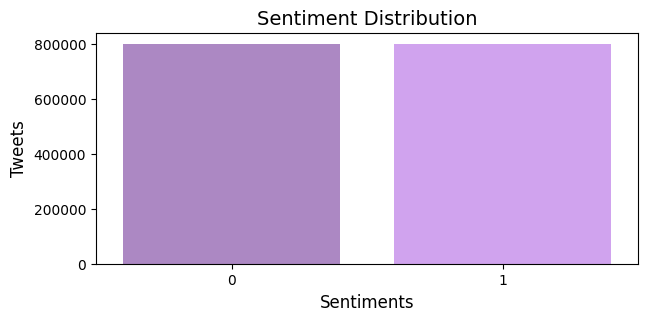

In [ ]:
import seaborn as sns

plt.figure(figsize=(7,3))
colors = sns.dark_palette("#d397fa", n_colors=10, input='rgb')
sns.countplot(data=df, x='sentiment', palette=[colors[7], colors[9]])
plt.xlabel("Sentiments", size=12)
plt.ylabel('Tweets', size=12)
plt.title("Sentiment Distribution", size=14)
plt.show()

<Axes: >

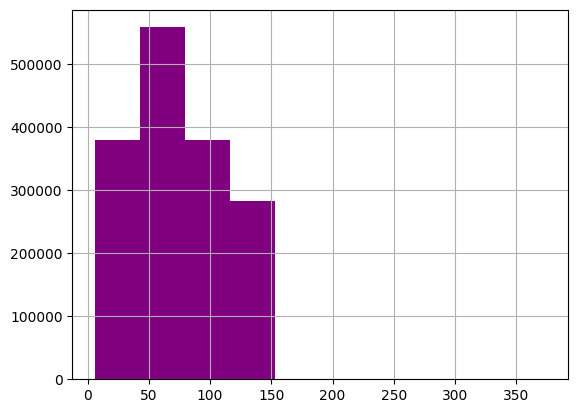

In [ ]:
df['text'].str.len().hist(color='purple') # number of characters present in each sentence

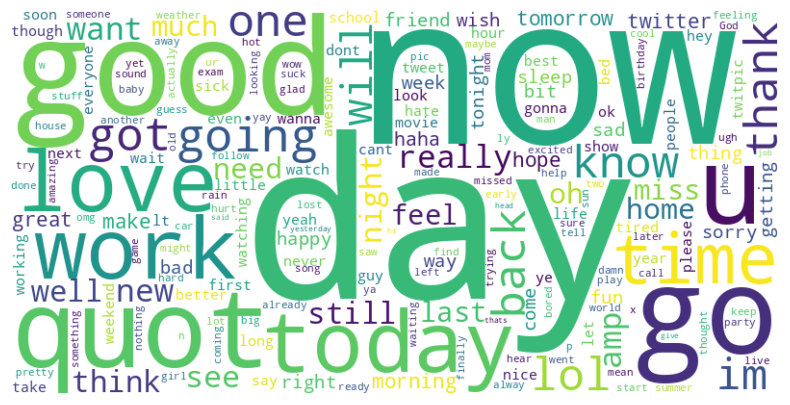

In [ ]:
# Generate a word cloud based on the raw text (before preprocessing)
raw_text_data = ' '.join(df[df.columns[5]].astype(str))  # Column 5 contains the raw text data

# Create the word cloud object using the raw text
wordcloud_raw = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(raw_text_data)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_raw, interpolation='bilinear')
plt.axis('off')  # No axes around the word cloud
plt.show()



### DATA PREPROCESSING

In [ ]:
def cleaning(text):
    # converting to lowercase, removing URL links, special characters, punctuations...
    text = text.lower() # converting to lowercase
    text = re.sub('https?://\S+|www\.\S+', '', text) # removing URL links
    text = re.sub(r"\b\d+\b", "", text) # removing number
    text = re.sub('<.*?>+', '', text) # removing special characters,
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) # punctuations
    text = re.sub('\n', '', text)
    text = re.sub('[’“”…]', '', text)
    #removing emoji:
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

    # removing short form:

    text=re.sub("isn't",'is not',text)
    text=re.sub("he's",'he is',text)
    text=re.sub("wasn't",'was not',text)
    text=re.sub("there's",'there is',text)
    text=re.sub("couldn't",'could not',text)
    text=re.sub("won't",'will not',text)
    text=re.sub("they're",'they are',text)
    text=re.sub("she's",'she is',text)
    text=re.sub("There's",'there is',text)
    text=re.sub("wouldn't",'would not',text)
    text=re.sub("haven't",'have not',text)
    text=re.sub("That's",'That is',text)
    text=re.sub("you've",'you have',text)
    text=re.sub("He's",'He is',text)
    text=re.sub("what's",'what is',text)
    text=re.sub("weren't",'were not',text)
    text=re.sub("we're",'we are',text)
    text=re.sub("hasn't",'has not',text)
    text=re.sub("you'd",'you would',text)
    text=re.sub("shouldn't",'should not',text)
    text=re.sub("let's",'let us',text)
    text=re.sub("they've",'they have',text)
    text=re.sub("You'll",'You will',text)
    text=re.sub("i'm",'i am',text)
    text=re.sub("we've",'we have',text)
    text=re.sub("it's",'it is',text)
    text=re.sub("don't",'do not',text)
    text=re.sub("that´s",'that is',text)
    text=re.sub("I´m",'I am',text)
    text=re.sub("it’s",'it is',text)
    text=re.sub("she´s",'she is',text)
    text=re.sub("he’s'",'he is',text)
    text=re.sub('I’m','I am',text)
    text=re.sub('I’d','I did',text)
    text=re.sub("he’s'",'he is',text)
    text=re.sub('there’s','there is',text)


    return text

In [ ]:
df['sentiment']

,sentiment
0,0
1,0
2,0
3,0
4,0
...,...
1599994,1
1599995,1
1599996,1
1599997,1


In [ ]:
dt = df['text'].apply(cleaning)

In [ ]:
dt = pd.DataFrame(dt);
dt['sentiment']=df['sentiment']
dt

,text,sentiment
0,is upset that he cant update his facebook by t...,0
1,kenichan i dived many times for the ball manag...,0
2,my whole body feels itchy and like its on fire,0
3,nationwideclass no its not behaving at all im ...,0
4,kwesidei not the whole crew,0
...,...,...
1599994,just woke up having no school is the best feel...,1
1599995,thewdbcom very cool to hear old walt intervie...,1
1599996,are you ready for your mojo makeover ask me fo...,1
1599997,happy 38th birthday to my boo of alll time tup...,1


In [ ]:
# Getting list of stopwords
stop_words = set(stopwords.words('english'))

# Removing all Stopwords
dt['no_sw'] = dt['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [ ]:
dt

,text,sentiment,no_sw
0,is upset that he cant update his facebook by t...,0,upset cant update facebook texting might cry r...
1,kenichan i dived many times for the ball manag...,0,kenichan dived many times ball managed save re...
2,my whole body feels itchy and like its on fire,0,whole body feels itchy like fire
3,nationwideclass no its not behaving at all im ...,0,nationwideclass behaving im mad cant see
4,kwesidei not the whole crew,0,kwesidei whole crew
...,...,...,...
1599994,just woke up having no school is the best feel...,1,woke school best feeling ever
1599995,thewdbcom very cool to hear old walt intervie...,1,thewdbcom cool hear old walt interviews â«
1599996,are you ready for your mojo makeover ask me fo...,1,ready mojo makeover ask details
1599997,happy 38th birthday to my boo of alll time tup...,1,happy 38th birthday boo alll time tupac amaru ...


In [ ]:
#Working with the most Frequent Words:
from collections import Counter
cnt = Counter()
for text in dt["no_sw"].values:
    for word in text.split():
        cnt[word] += 1
cnt.most_common(10)
temp = pd.DataFrame(cnt.most_common(10))
temp.columns=['word', 'count']
temp

,word,count
0,im,177513
1,good,89407
2,day,82519
3,get,81489
4,like,77775
5,go,72922
6,dont,66933
7,today,64623
8,going,64091
9,love,63476


In [ ]:
fig = px.bar(temp,
             x="count",
             y="word",
             title='Common Words in Text',
             orientation='h',
             width=500,
             height=500,
             color_discrete_sequence=['purple'])

fig.show()

In [ ]:
# Remove the most frequent words:
FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])
def remove_freqwords(text):
    """custom function to remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])
dt["wo_stopfreq"] = dt["no_sw"].apply(lambda text: remove_freqwords(text))
dt.head()

,text,sentiment,no_sw,wo_stopfreq
0,is upset that he cant update his facebook by t...,0,upset cant update facebook texting might cry r...,upset cant update facebook texting might cry r...
1,kenichan i dived many times for the ball manag...,0,kenichan dived many times ball managed save re...,kenichan dived many times ball managed save re...
2,my whole body feels itchy and like its on fire,0,whole body feels itchy like fire,whole body feels itchy fire
3,nationwideclass no its not behaving at all im ...,0,nationwideclass behaving im mad cant see,nationwideclass behaving mad cant see
4,kwesidei not the whole crew,0,kwesidei whole crew,kwesidei whole crew


In [ ]:
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

# Applying Lemmatization
dt['wo_stopfreq_lem'] = dt['wo_stopfreq'].apply(lemmatizer.lemmatize)
dt

[nltk_data] Downloading package wordnet to /root/nltk_data...


,text,sentiment,no_sw,wo_stopfreq,wo_stopfreq_lem
0,is upset that he cant update his facebook by t...,0,upset cant update facebook texting might cry r...,upset cant update facebook texting might cry r...,upset cant update facebook texting might cry r...
1,kenichan i dived many times for the ball manag...,0,kenichan dived many times ball managed save re...,kenichan dived many times ball managed save re...,kenichan dived many times ball managed save re...
2,my whole body feels itchy and like its on fire,0,whole body feels itchy like fire,whole body feels itchy fire,whole body feels itchy fire
3,nationwideclass no its not behaving at all im ...,0,nationwideclass behaving im mad cant see,nationwideclass behaving mad cant see,nationwideclass behaving mad cant see
4,kwesidei not the whole crew,0,kwesidei whole crew,kwesidei whole crew,kwesidei whole crew
...,...,...,...,...,...
1599994,just woke up having no school is the best feel...,1,woke school best feeling ever,woke school best feeling ever,woke school best feeling ever
1599995,thewdbcom very cool to hear old walt intervie...,1,thewdbcom cool hear old walt interviews â«,thewdbcom cool hear old walt interviews â«,thewdbcom cool hear old walt interviews â«
1599996,are you ready for your mojo makeover ask me fo...,1,ready mojo makeover ask details,ready mojo makeover ask details,ready mojo makeover ask details
1599997,happy 38th birthday to my boo of alll time tup...,1,happy 38th birthday boo alll time tupac amaru ...,happy 38th birthday boo alll time tupac amaru ...,happy 38th birthday boo alll time tupac amaru ...


In [ ]:
# create the cleaned data for the train-test split:
nb=dt.drop(columns=['text','no_sw', 'wo_stopfreq'])
nb.columns=['sentiment','text']
nb

,sentiment,text
0,0,upset cant update facebook texting might cry r...
1,0,kenichan dived many times ball managed save re...
2,0,whole body feels itchy fire
3,0,nationwideclass behaving mad cant see
4,0,kwesidei whole crew
...,...,...
1599994,1,woke school best feeling ever
1599995,1,thewdbcom cool hear old walt interviews â«
1599996,1,ready mojo makeover ask details
1599997,1,happy 38th birthday boo alll time tupac amaru ...


In [ ]:
tokenized_text=dt['text'].apply(lambda x: x.split())
tokenized_text.head(5)

,text
0,"[is, upset, that, he, cant, update, his, faceb..."
1,"[kenichan, i, dived, many, times, for, the, ba..."
2,"[my, whole, body, feels, itchy, and, like, its..."
3,"[nationwideclass, no, its, not, behaving, at, ..."
4,"[kwesidei, not, the, whole, crew]"


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)
text_counts = cv.fit_transform(nb['text'])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'





# Split the data

In [ ]:
print("Label distribution:\n", dt['sentiment'].value_counts())

Label distribution:
 sentiment
1    800000
0    799999
Name: count, dtype: int64


In [ ]:
# Split the data (train_test_split with stratify to preserve class distribution)
X = dt['text']
y = dt['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


from sklearn.feature_extraction.text import TfidfVectorizer
# Vectorize text data using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# NB

In [ ]:
#  Multinomial Naive Bayes
mnb = MultinomialNB()
mnb.fit(X_train_tfidf, y_train)
y_pred_mnb = mnb.predict(X_test_tfidf)


print("Multinomial Naive Bayes Accuracy = {:.2f}%".format(accuracy_score(y_test, y_pred_mnb) * 100))
print('Confusion Matrix:')
print(pd.DataFrame(confusion_matrix(y_test, y_pred_mnb)))
print(classification_report(y_test, y_pred_mnb))

Multinomial Naive Bayes Accuracy = 75.38%
Confusion Matrix:
        0       1
0  118789   41211
1   37580  122420
              precision    recall  f1-score   support

           0       0.76      0.74      0.75    160000
           1       0.75      0.77      0.76    160000

    accuracy                           0.75    320000
   macro avg       0.75      0.75      0.75    320000
weighted avg       0.75      0.75      0.75    320000



In [ ]:
#  Bernoulli Naive Bayes
bnb = BernoulliNB()
bnb.fit(X_train_tfidf, y_train)
y_pred_bnb = bnb.predict(X_test_tfidf)

print("Bernoulli Naive Bayes Accuracy = {:.2f}%".format(accuracy_score(y_test, y_pred_bnb) * 100))
print('Confusion Matrix:')
print(pd.DataFrame(confusion_matrix(y_test, y_pred_bnb)))
print(classification_report(y_test, y_pred_bnb))

Bernoulli Naive Bayes Accuracy = 75.86%
Confusion Matrix:
        0       1
0  118137   41863
1   35396  124604
              precision    recall  f1-score   support

           0       0.77      0.74      0.75    160000
           1       0.75      0.78      0.76    160000

    accuracy                           0.76    320000
   macro avg       0.76      0.76      0.76    320000
weighted avg       0.76      0.76      0.76    320000



In [ ]:
# Complement Naive Bayes
cnb = ComplementNB()
cnb.fit(X_train_tfidf, y_train)
y_pred_cnb = cnb.predict(X_test_tfidf)

print("Complement Naive Bayes Accuracy =  {:.2f}%".format(accuracy_score(y_test, y_pred_cnb)* 100))
print('Confusion Matrix:')
print(pd.DataFrame(confusion_matrix(y_test, y_pred_cnb)))
print(classification_report(y_test, y_pred_cnb))

Complement Naive Bayes Accuracy =  75.20%
Confusion Matrix:
        0       1
0  121360   38640
1   40715  119285
              precision    recall  f1-score   support

           0       0.75      0.76      0.75    160000
           1       0.76      0.75      0.75    160000

    accuracy                           0.75    320000
   macro avg       0.75      0.75      0.75    320000
weighted avg       0.75      0.75      0.75    320000



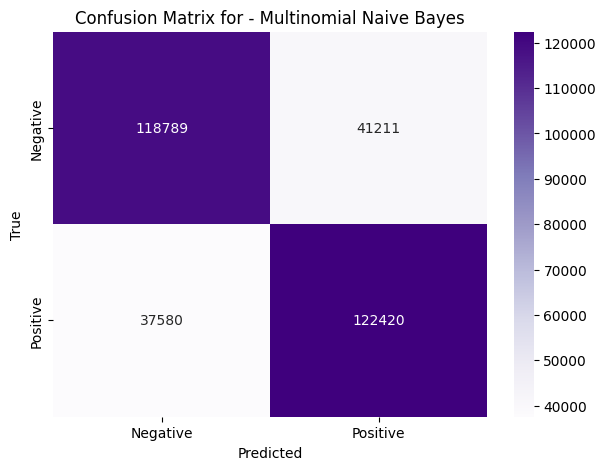

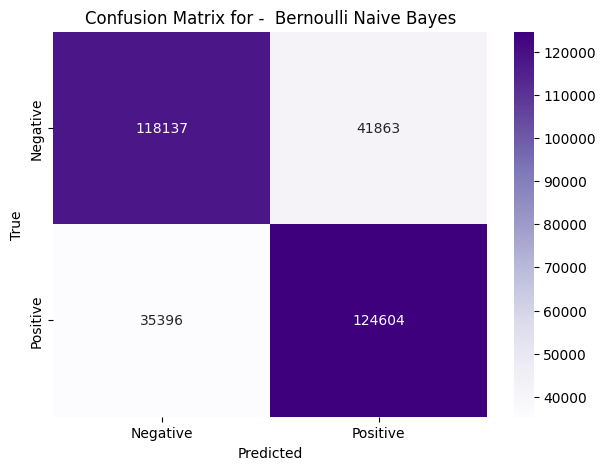

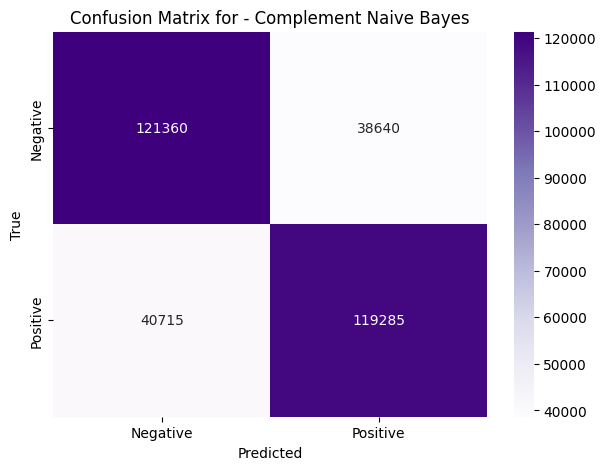

In [ ]:
# confusion matrices
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7,5 ))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    # Plot confusion matrices for each model
plot_confusion_matrix(y_test, y_pred_mnb, 'Confusion Matrix for - Multinomial Naive Bayes')
plot_confusion_matrix(y_test, y_pred_bnb, 'Confusion Matrix for -  Bernoulli Naive Bayes')
plot_confusion_matrix(y_test, y_pred_cnb, 'Confusion Matrix for - Complement Naive Bayes')

AUC scores:
Complement NB: 0.8358438464648437 
Multinomial NB: 0.8358438464843749 
Bernoulli NB: 0.8350223467578124


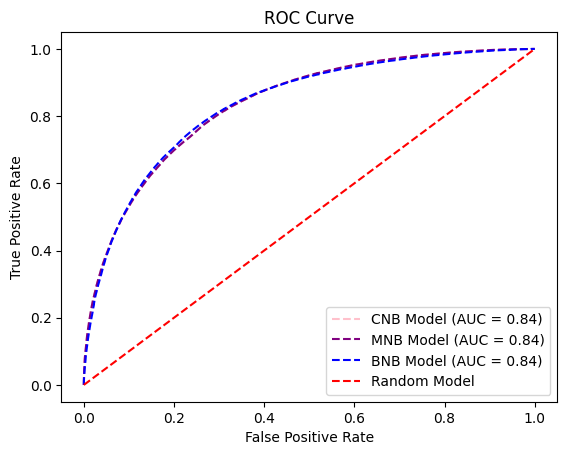

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# Predict probabilities for CNB, MNB, BNB models
cnb_prob = cnb.predict_proba(X_test_tfidf)
mnb_prob = mnb.predict_proba(X_test_tfidf)
bnb_prob = bnb.predict_proba(X_test_tfidf)

# ROC curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, cnb_prob[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, mnb_prob[:,1], pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(y_test, bnb_prob[:,1], pos_label=1)

# ROC curve for random predictions (tpr = fpr)
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

# AUC scores
auc_cnb = roc_auc_score(y_test, cnb_prob[:,1])
auc_mnb = roc_auc_score(y_test, mnb_prob[:,1])
auc_bnb = roc_auc_score(y_test, bnb_prob[:,1])

print("AUC scores:\nComplement NB:", auc_cnb, "\nMultinomial NB:", auc_mnb, "\nBernoulli NB:", auc_bnb)

# Plot ROC curves
plt.plot(fpr1, tpr1, linestyle='--', color='pink', label='CNB Model (AUC = {:.2f})'.format(auc_cnb))
plt.plot(fpr2, tpr2, linestyle='--', color='purple', label='MNB Model (AUC = {:.2f})'.format(auc_mnb))
plt.plot(fpr3, tpr3, linestyle='--', color='blue', label='BNB Model (AUC = {:.2f})'.format(auc_bnb))
plt.plot(p_fpr, p_tpr, linestyle='--', color='red', label='Random Model')

# Title and labels
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend(loc='best')
plt.savefig('ROC', dpi=300)
plt.show()


# LR

In [ ]:
#  a Logistic Regression model
lr = LogisticRegression(max_iter=200)
lr.fit(X_train_tfidf, y_train)

y_pred = lr.predict(X_test_tfidf)

print("Logistic Regression Accuracy = {:.2f}%".format(accuracy_score(y_test, y_pred)))
print('Confusion Matrix:')
print(pd.DataFrame(confusion_matrix(y_test, y_pred)))
print(classification_report(y_test, y_pred))

Logistic Regression Accuracy = 0.77%
Confusion Matrix:
        0       1
0  118292   41708
1   33215  126785
              precision    recall  f1-score   support

           0       0.78      0.74      0.76    160000
           1       0.75      0.79      0.77    160000

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000



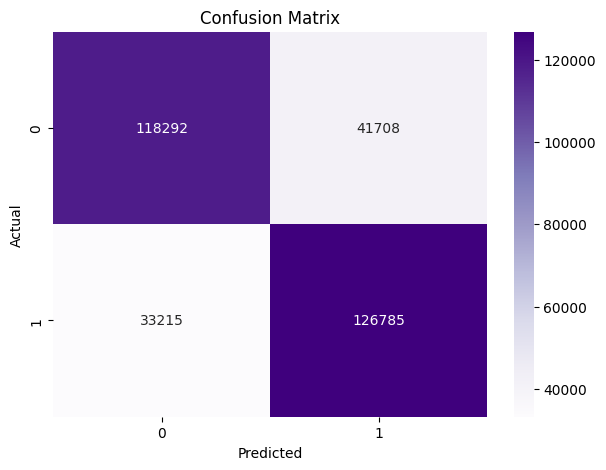

In [ ]:
plt.figure(figsize=(7,5))
# Calculating and storing the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred) # Assuming y_test and y_pred are defined
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Purples', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()